# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Case-Study---Binary-Classification" data-toc-modified-id="Case-Study---Binary-Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case Study - Binary Classification</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preprocessing" data-toc-modified-id="Data-Visualization-&amp;-Preprocessing-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Visualization &amp; Preprocessing</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic Regression Model</a></div><div class="lev2 toc-item"><a href="#Deep-Model" data-toc-modified-id="Deep-Model-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Deep Model</a></div><div class="lev2 toc-item"><a href="#Even-deeper-model" data-toc-modified-id="Even-deeper-model-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Even deeper model</a></div><div class="lev1 toc-item"><a href="#Case-Study---MultiClass-Classification" data-toc-modified-id="Case-Study---MultiClass-Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Case Study - MultiClass Classification</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preparation" data-toc-modified-id="Data-Visualization-&amp;-Preparation-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Visualization &amp; Preparation</a></div><div class="lev1 toc-item"><a href="#Case-Study---Regression" data-toc-modified-id="Case-Study---Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Case Study - Regression</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preparation" data-toc-modified-id="Data-Visualization-&amp;-Preparation-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Visualization &amp; Preparation</a></div><div class="lev2 toc-item"><a href="#Linear-Regression-Model" data-toc-modified-id="Linear-Regression-Model-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Regression Model</a></div><div class="lev2 toc-item"><a href="#Deep-Model" data-toc-modified-id="Deep-Model-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Deep Model</a></div>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [2]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Case Study - Binary Classification

We will be using the Human Resources Analytics dataset on Kaggle: https://www.kaggle.com/ludobenistant/hr-analytics

We're trying to predict whether an employee will leave based on various features such as number of projects they worked on, time spent at the company, last performance review, salary etc. The dataset has around 15,000 rows and 9 columns. The column we're trying to predict is called "left". It's a binary column with 0/1 values. The label 1 means that the employee has left.

## Data Visualization & Preprocessing

In [3]:
rawdf = pd.read_csv('../data/HR.csv')
rawdf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [4]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_monthly_hours    14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
left                     14999 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
rawdf.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00"
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.02,0.24
std,0.25,0.17,1.23,49.94,1.46,0.35,0.14,0.43
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


In [6]:
(rawdf['left'].value_counts())/rawdf['left'].count()

0   0.76
1   0.24
Name: left, dtype: float64

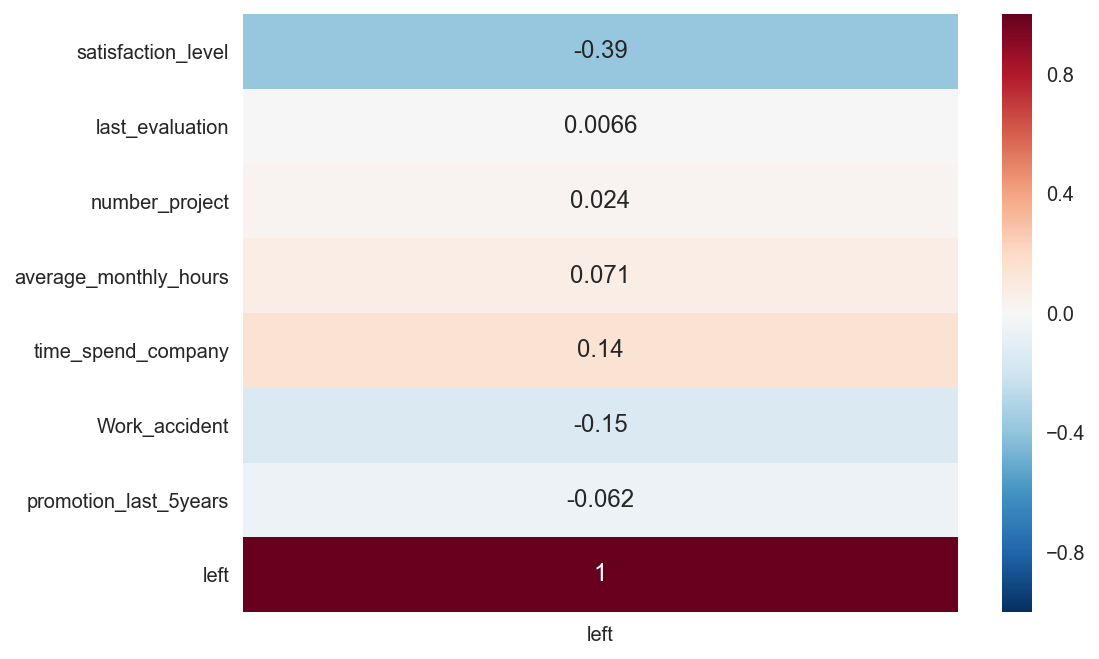

In [7]:
sns.heatmap(rawdf.corr()[['left']], annot=True, vmin=-1, vmax=1)

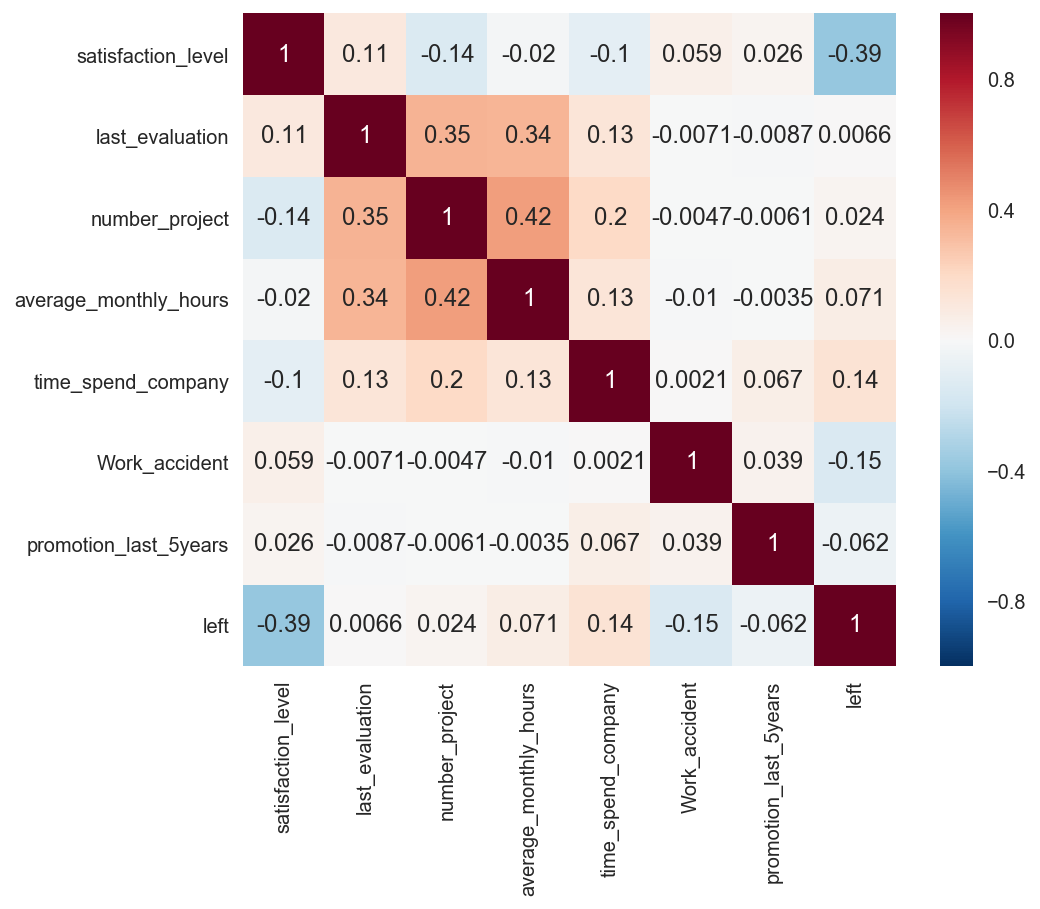

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(rawdf.corr(), annot = True, square=True, vmin=-1, vmax=1)

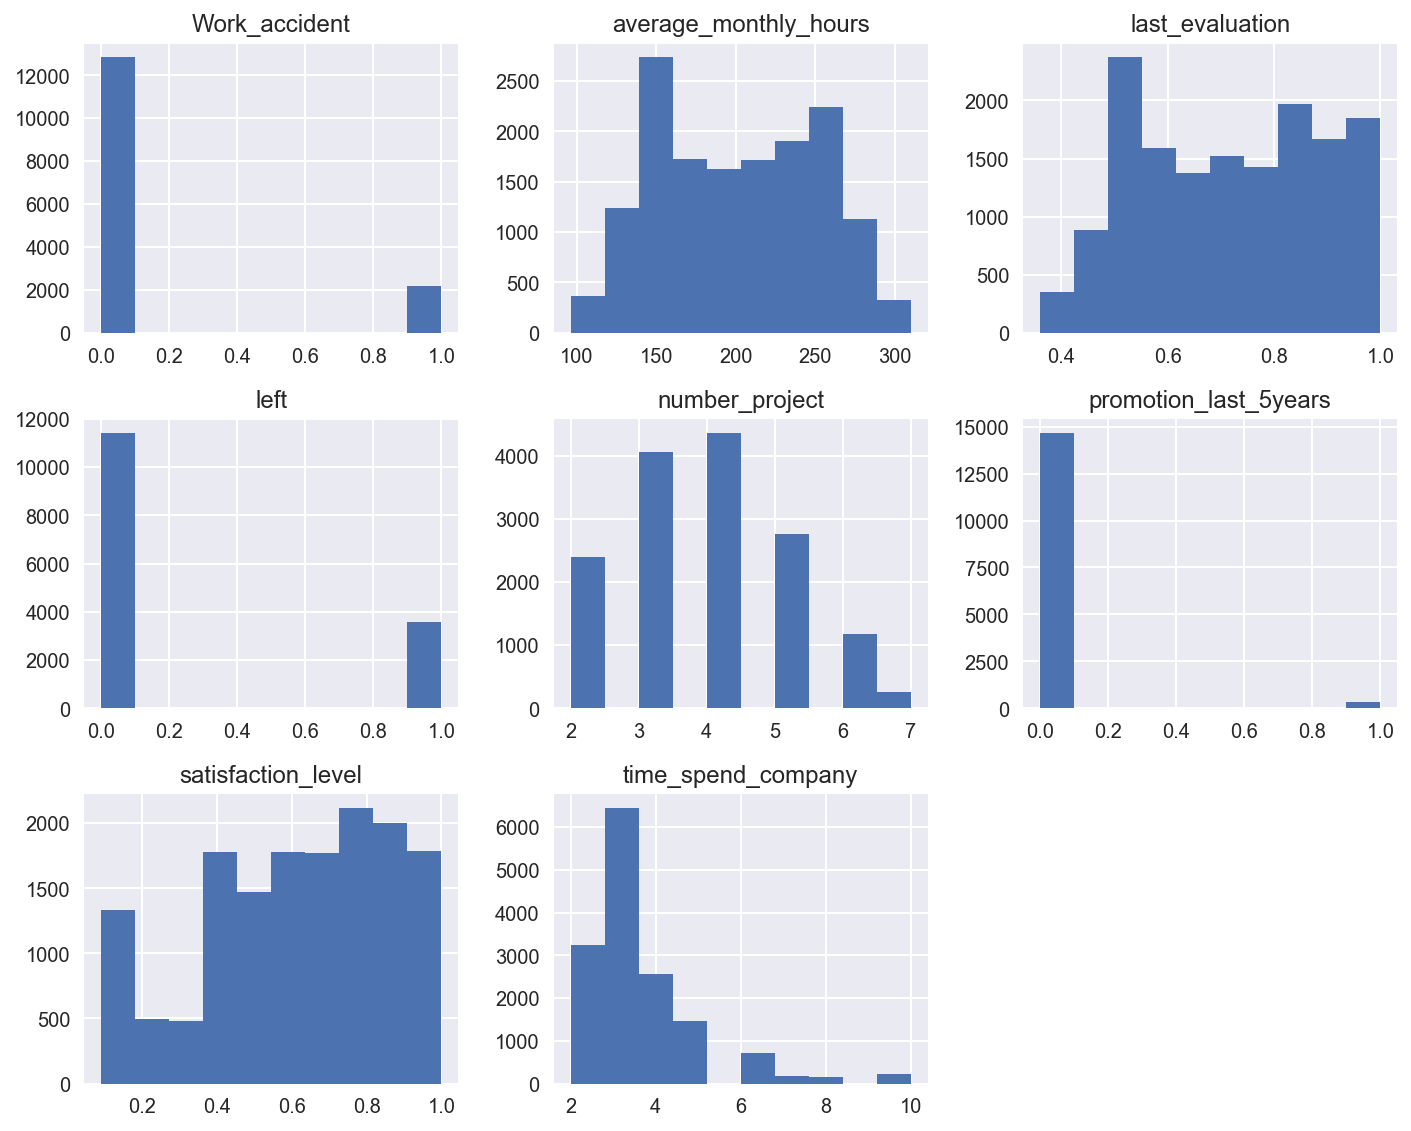

In [9]:
rawdf.hist(figsize=(10, 8))
plt.tight_layout()

In [10]:
df = rawdf.copy()

ss = StandardScaler()
scale_features = ['average_monthly_hours', 'number_project', 'time_spend_company']
df[scale_features] = ss.fit_transform(df[scale_features])

categorical_features = ['sales', 'salary']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,-1.46,-0.88,-0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,0.97,1.22,1.71,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,2.59,1.42,0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,0.97,0.44,1.03,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,-1.46,-0.84,-0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [11]:
df.filter(regex=("salary.*")).sample(n=5)

,salary_high,salary_low,salary_medium
3195,1,0,0
14708,0,0,1
6455,1,0,0
13013,0,1,0
8982,0,1,0


In [12]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00"
mean,0.61,0.72,0.00,-0.00,-0.00,0.14,0.02,0.24,0.08,0.05,0.05,0.05,0.04,0.06,0.06,0.28,0.15,0.18,0.08,0.49,0.43
std,0.25,0.17,1.00,1.00,1.00,0.35,0.14,0.43,0.27,0.22,0.22,0.22,0.20,0.23,0.24,0.45,0.36,0.39,0.28,0.50,0.50
min,0.09,0.36,-1.46,-2.10,-1.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.44,0.56,-0.65,-0.90,-0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.64,0.72,0.16,-0.02,-0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.82,0.87,0.97,0.88,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00
max,1.00,1.00,2.59,2.18,4.45,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [13]:
X = df.drop('left', axis=1).values
y = df['left'].values
X, y = shuffle(X, y, random_state=0)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14999, 20) (14999,)
(10499, 20) (10499,) (4500, 20) (4500,)


## Logistic Regression Model

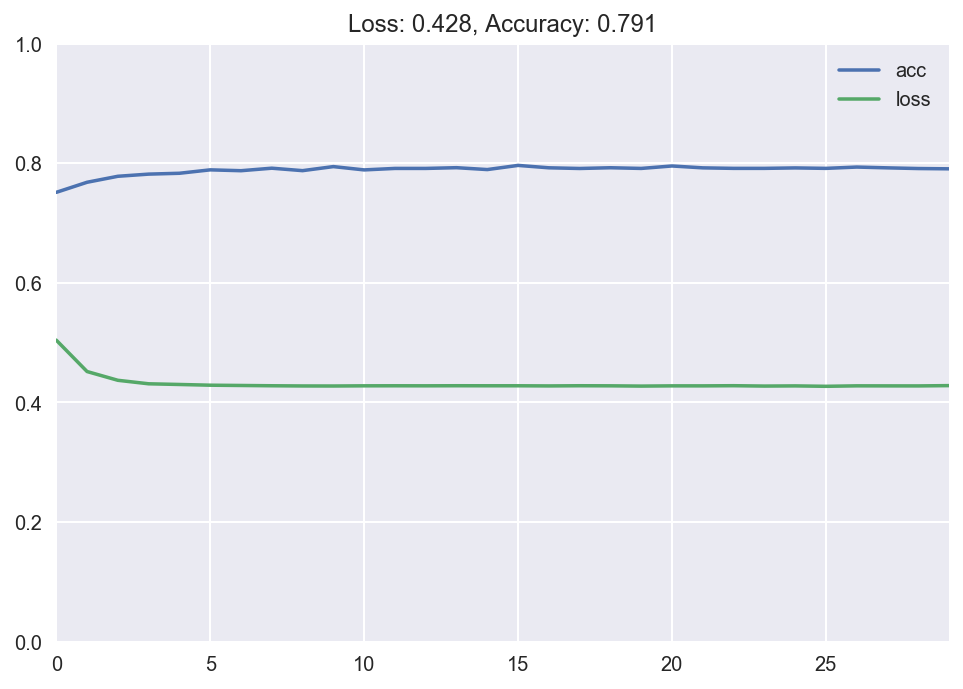

In [42]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))

lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

lr_history = lr_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(lr_history)

             precision    recall  f1-score   support

          0       0.82      0.92      0.87      3376
          1       0.62      0.38      0.47      1124

avg / total       0.77      0.79      0.77      4500



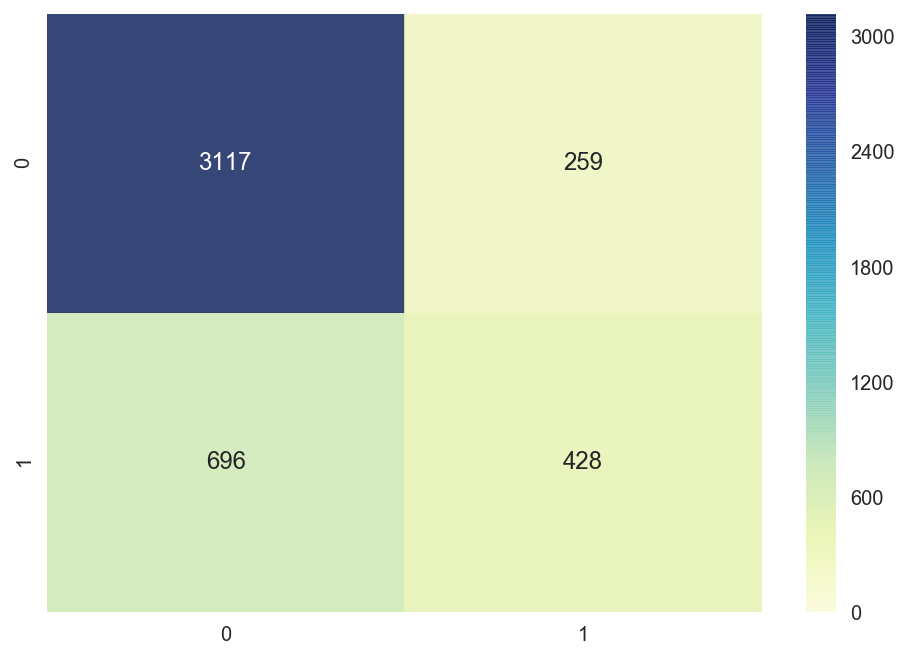

In [43]:
y_pred = lr_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_model, X_test, y_test)

In [17]:
def get_model():
    return lr_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[ 0.797       0.80066667  0.76633333  0.77533333  0.80693564]
Accuracy: 78.93% (+/- 3.13%)


## Deep Model

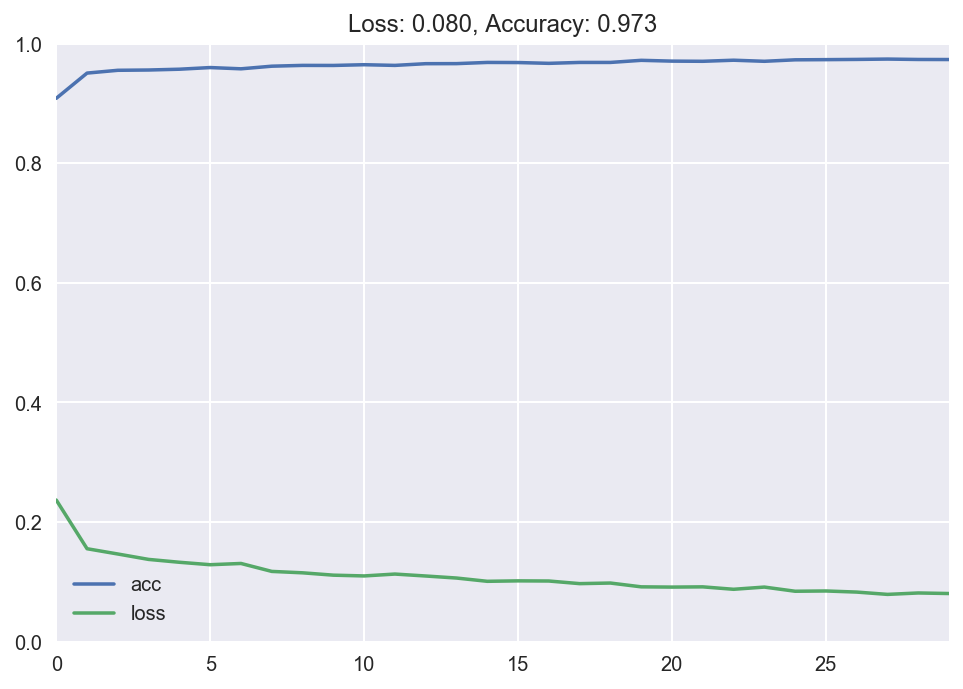

In [46]:
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

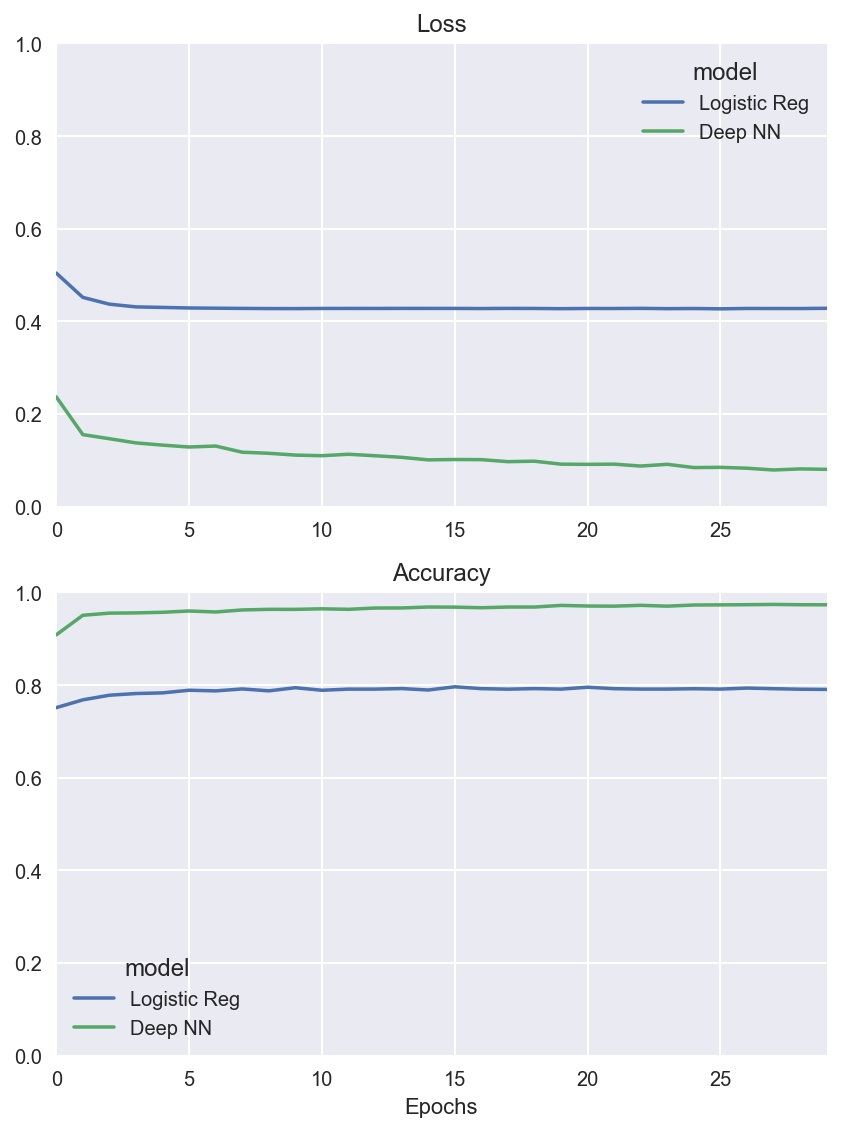

In [48]:
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep NN'])

             precision    recall  f1-score   support

          0       0.97      0.98      0.97      3376
          1       0.94      0.90      0.92      1124

avg / total       0.96      0.96      0.96      4500



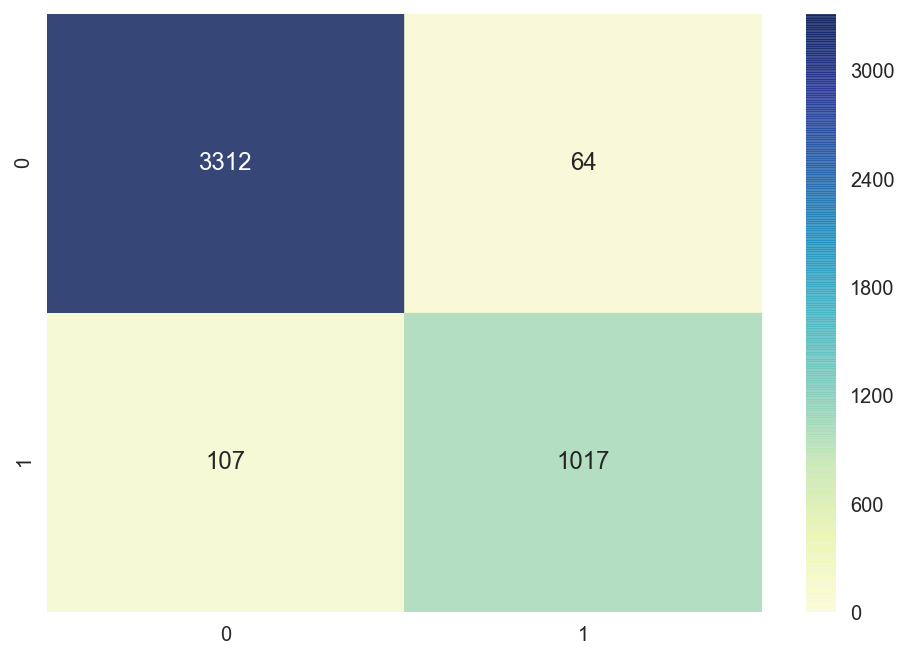

In [47]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

In [22]:
def get_model():
    return deep_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[ 0.966       0.963       0.96966667  0.96633333  0.97032344]
Accuracy: 96.71% (+/- 0.53%)


In [50]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model_vis.add(Dense(16, activation='tanh'))
deep_model_vis.add(Dense(2, activation='tanh'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_model_vis.fit(X_train, y_train, verbose=0, epochs=30)

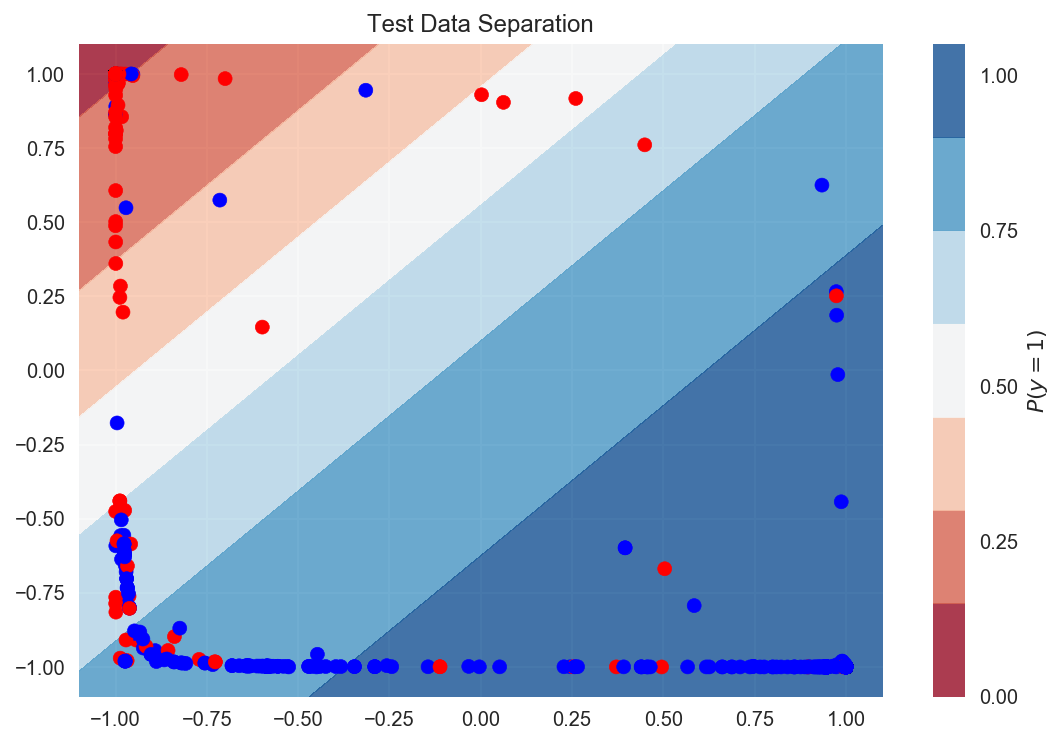

In [52]:
inp = deep_model_vis.layers[0].input
out = deep_model_vis.layers[2].output

# input to 2-D mapping
func1 = K.function([inp], [out])

# 2-D to score prediction
func2 = K.function([deep_model_vis.layers[3].input], [deep_model_vis.layers[3].output])

features = func1([X_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

## Even deeper model

Epoch 1/10
10499/10499 [==============================] - 1s - loss: 0.2228 - acc: 0.9151     
Epoch 2/10
10499/10499 [==============================] - 0s - loss: 0.1506 - acc: 0.9529     
Epoch 3/10
10499/10499 [==============================] - 0s - loss: 0.1390 - acc: 0.9566     
Epoch 4/10
10499/10499 [==============================] - 0s - loss: 0.1330 - acc: 0.9587     
Epoch 5/10
10499/10499 [==============================] - 0s - loss: 0.1266 - acc: 0.9614     
Epoch 6/10
10499/10499 [==============================] - 0s - loss: 0.1213 - acc: 0.9630     
Epoch 7/10
10499/10499 [==============================] - 0s - loss: 0.1202 - acc: 0.9632     
Epoch 8/10
10499/10499 [==============================] - 0s - loss: 0.1191 - acc: 0.9612     
Epoch 9/10
10499/10499 [==============================] - 0s - loss: 0.1132 - acc: 0.9649     
Epoch 10/10
10499/10499 [==============================] - 0s - loss: 0.1082 - acc: 0.9662     


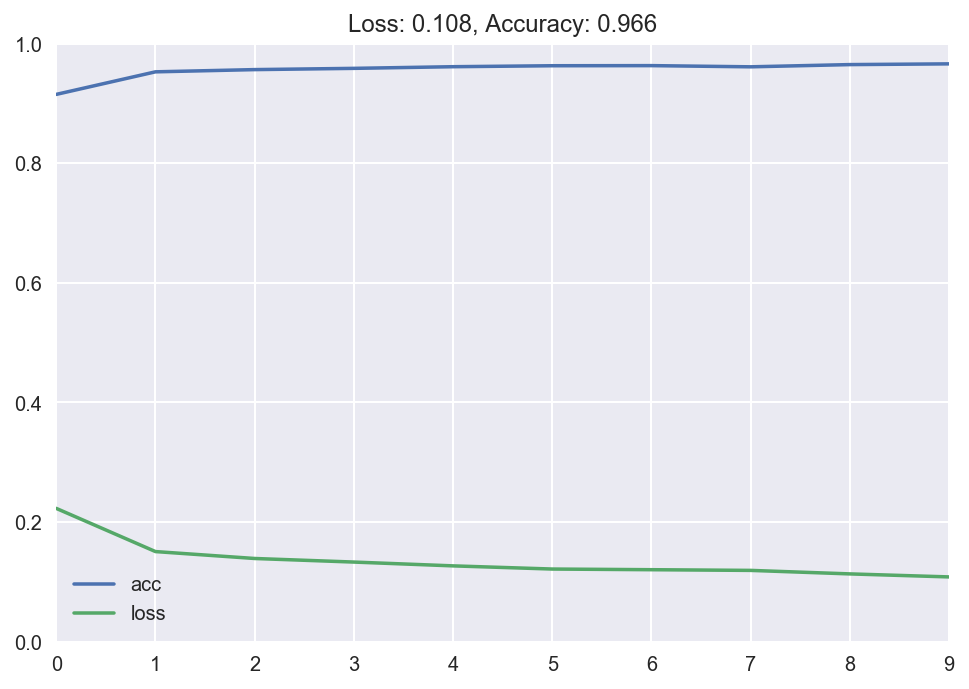

In [25]:
deeper_model = Sequential()
deeper_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deeper_model.add(Dense(64, activation='tanh'))
deeper_model.add(Dense(1, activation='sigmoid'))

deeper_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deeper_history = deeper_model.fit(X_train, y_train, verbose=1, epochs=10)
plot_loss_accuracy(deeper_history)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3376
          1       0.96      0.92      0.94      1124

avg / total       0.97      0.97      0.97      4500



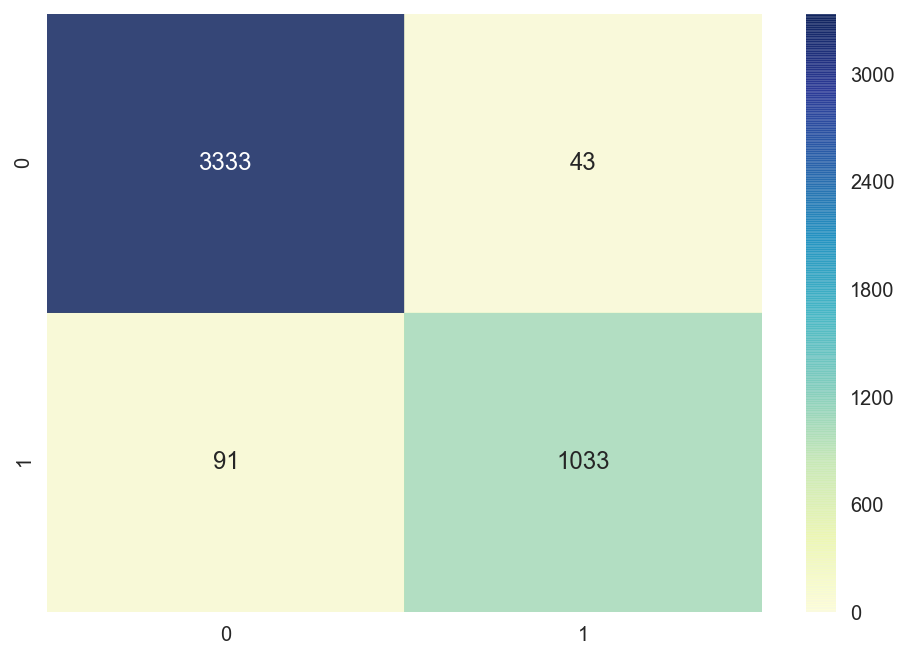

In [26]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

# Case Study - MultiClass Classification

We will be using the well known Iris dataset.

## Data Visualization & Preparation

In [73]:
df = pd.read_csv('../data/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa


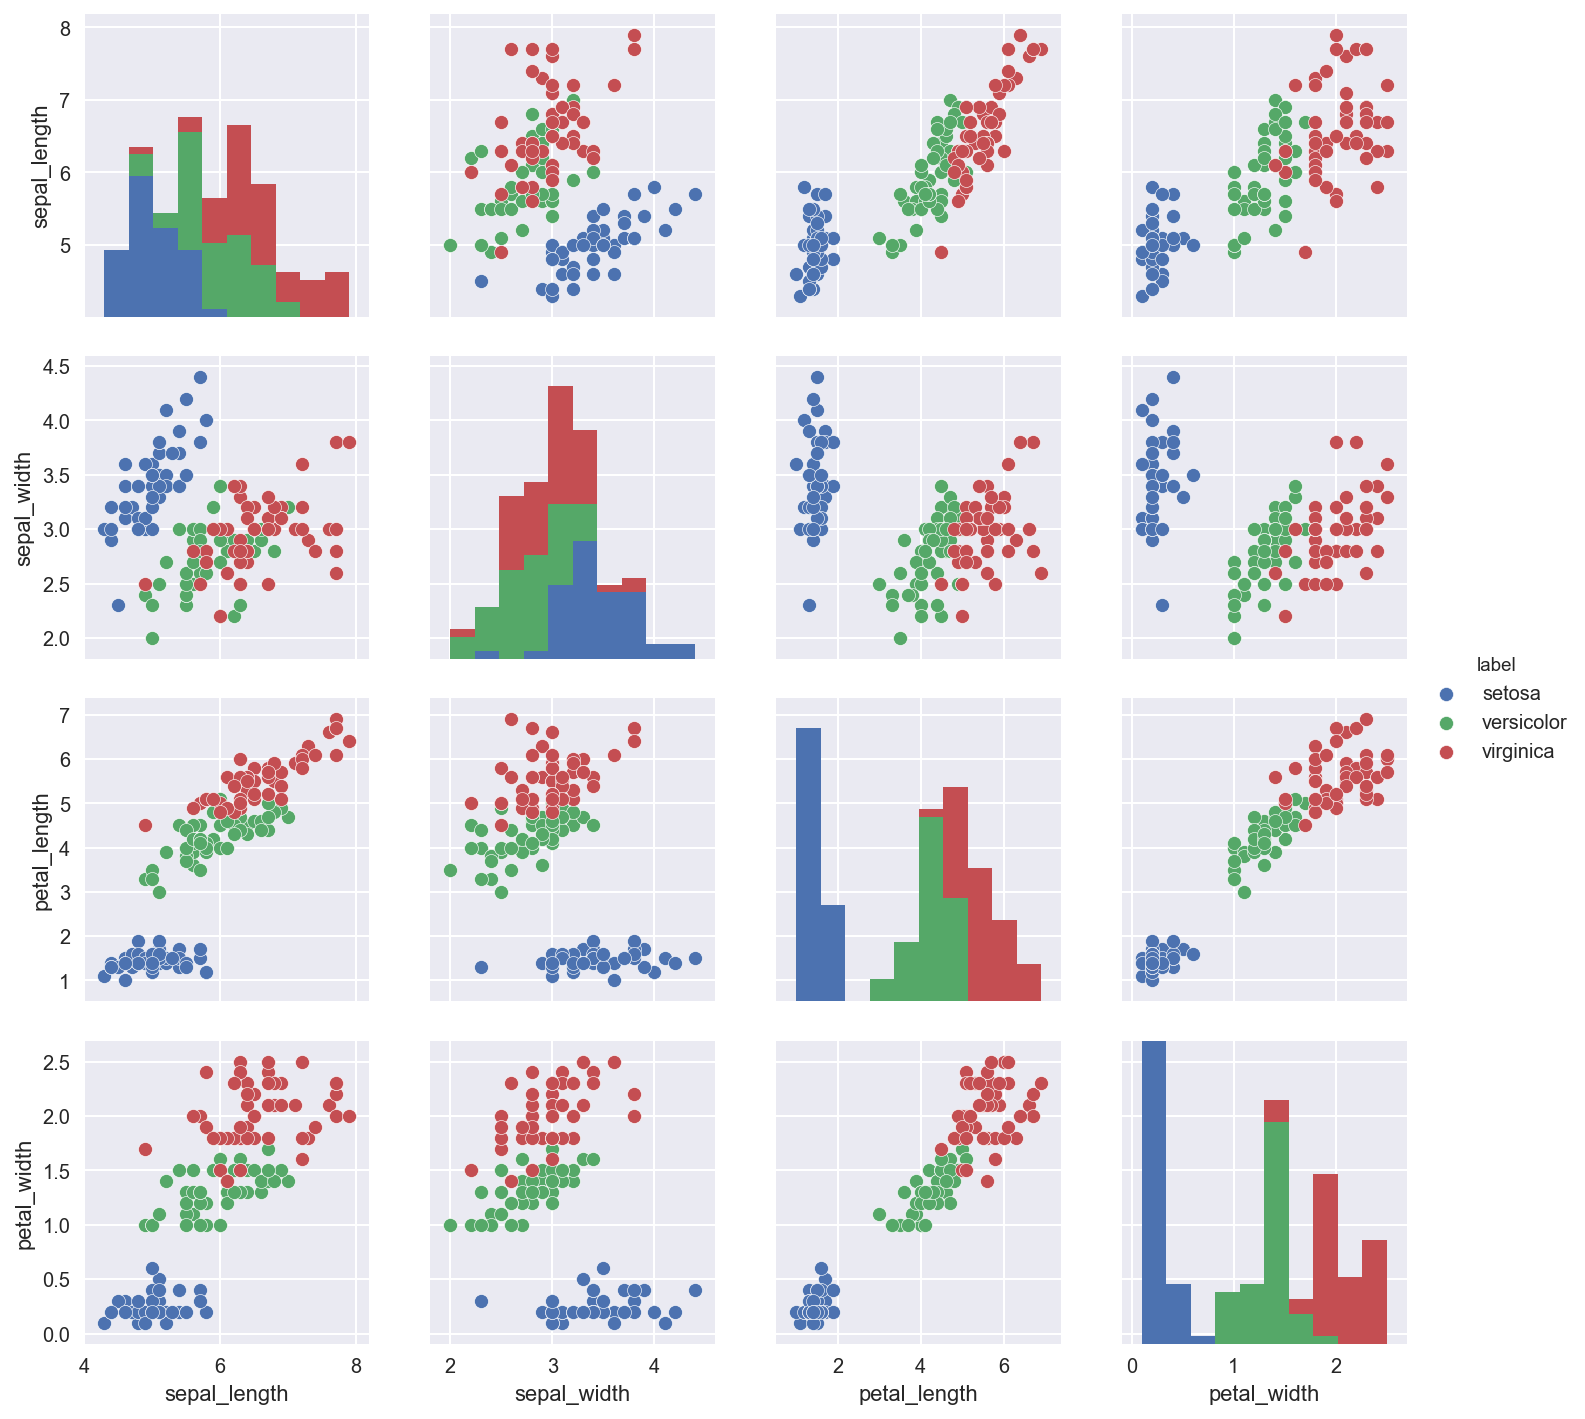

In [55]:
sns.pairplot(df, hue='label')

In [74]:
X = df.values[:, :-1]
y = pd.get_dummies(df['label']).values
print(X.shape, y.shape)

(150, 4) (150, 3)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)

(120, 4) (120, 3)


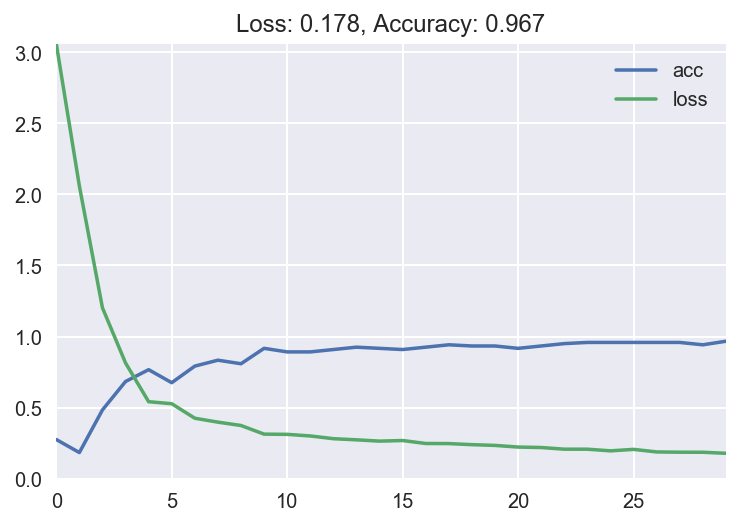

In [103]:
model = Sequential()
model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))

model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, verbose=0)
plot_loss_accuracy(history)

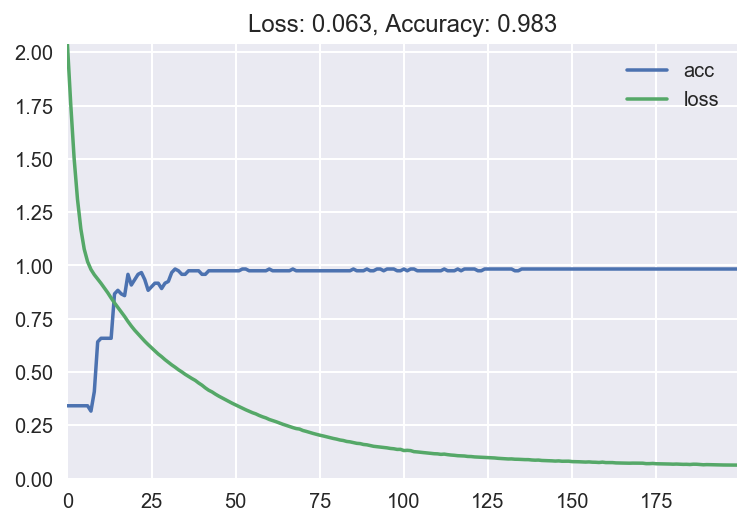

In [109]:
model = Sequential()
model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, verbose=0)
plot_loss_accuracy(history)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         9
          1       0.88      0.78      0.82         9
          2       0.85      0.92      0.88        12

avg / total       0.90      0.90      0.90        30



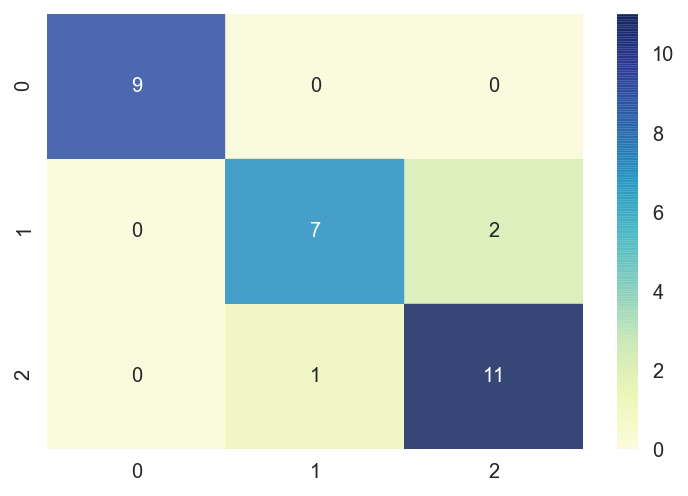

In [104]:
y_pred_class = model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model, X_test, y_test_class)

In [117]:
def get_linear_model():
    model = Sequential()
    model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))
    model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_deep_model():
    model = Sequential()
    model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(lr=0.03), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cv = StratifiedKFold(n_splits=5, random_state=0)

lin_model = KerasClassifier(build_fn=get_linear_model, epochs=50, verbose=0)
lin_scores = cross_val_score(lin_model, X, df['label'].values, cv=cv)
print(lin_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*lin_scores.mean(), 100*lin_scores.std()*2))

deep_model = KerasClassifier(build_fn=get_deep_model, epochs=50, verbose=0)
deep_scores = cross_val_score(deep_model, X, df['label'].values, cv=cv)
print(deep_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*deep_scores.mean(), 100*deep_scores.std()*2))

[ 1.          1.          0.89999998  0.93333334  1.        ]
Accuracy: 96.67% (+/- 8.43%)
[ 1.          0.96666664  0.89999998  0.93333334  1.        ]
Accuracy: 96.00% (+/- 7.77%)


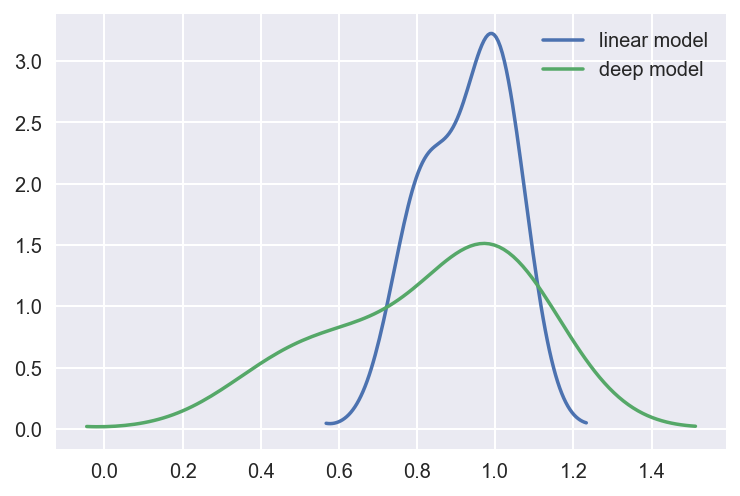

In [116]:
sns.distplot(lin_scores, hist=False, label='linear model')
sns.distplot(deep_scores, hist=False, label='deep model')

# Case Study - Regression

We will be using the house sales dataset from King County, WA on Kaggle: https://www.kaggle.com/harlfoxem/housesalesprediction

The data has around 21,000 rows with 20 features. The value we're tring to predict is a floating point number labeld as "price".

## Data Visualization & Preparation

In [543]:
rawdf = pd.read_csv('../data/kc_house_data.csv')
rawdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,"538,000.00",3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,"604,000.00",4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [544]:
rawdf.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
mean,"4,580,301,520.86","540,088.14",3.37,2.11,"2,079.90","15,106.97",1.49,0.01,0.23,3.41,7.66,"1,788.39",291.51,"1,971.01",84.40,"98,077.94",47.56,-122.21,"1,986.55","12,768.46"
std,"2,876,565,571.31","367,127.20",0.93,0.77,918.44,"41,420.51",0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,"27,304.18"
min,"1,000,102.00","75,000.00",0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,194.00","321,950.00",3.00,1.75,"1,427.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00",0.00,"1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00",0.00,"1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00","645,000.00",4.00,2.50,"2,550.00","10,688.00",2.00,0.00,0.00,4.00,8.00,"2,210.00",560.00,"1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","4,820.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


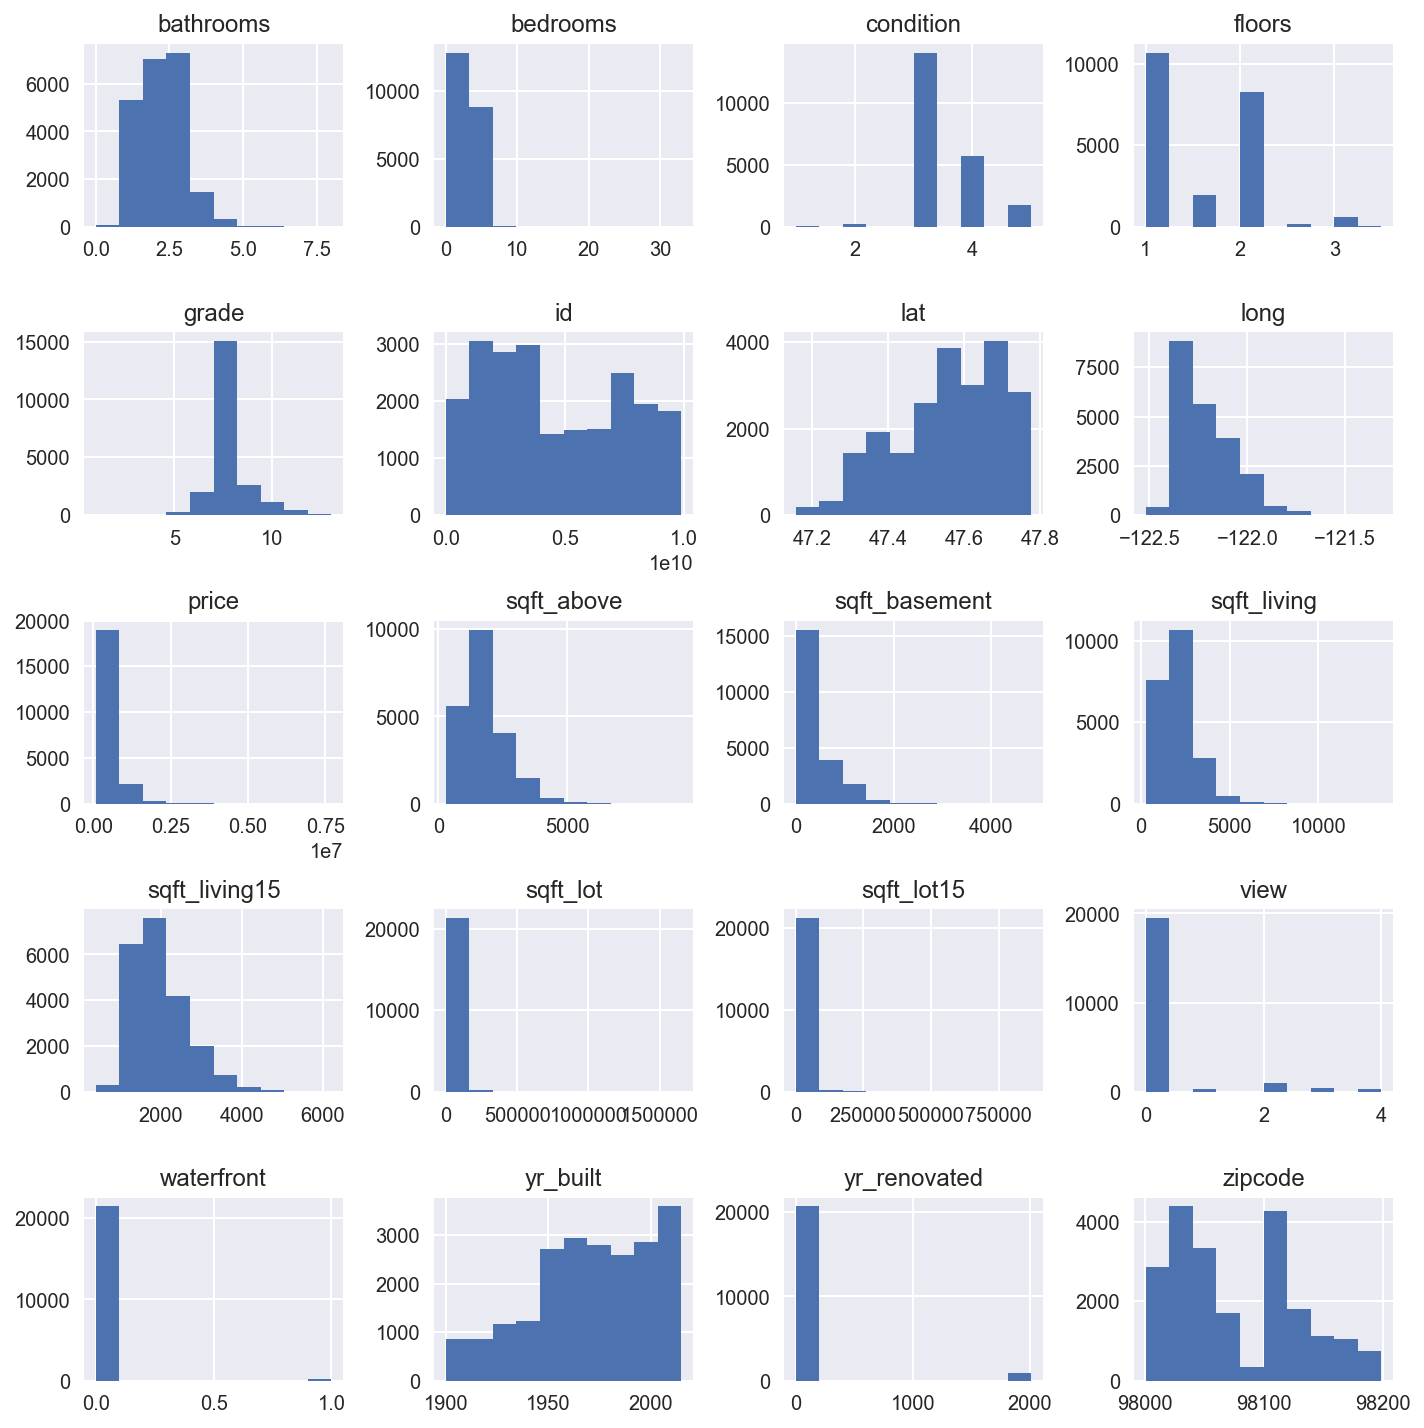

In [36]:
rawdf.hist(figsize=(10, 10))
plt.tight_layout()

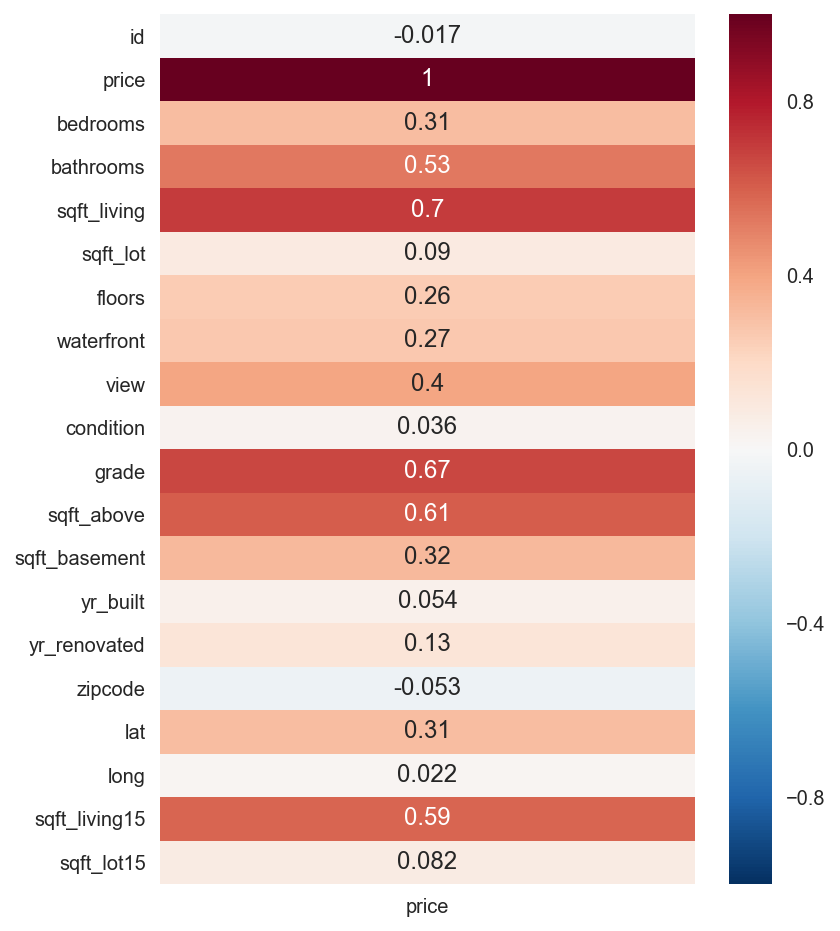

In [93]:
plt.figure(figsize=(6, 8))
sns.heatmap(rawdf.corr()[['price']], annot=True, vmin=-1, vmax=1)

In [545]:
df = rawdf.copy()

# features that need to be scaled
ss = StandardScaler()
scale_features = ['bathrooms', 'bedrooms', 'grade', 'sqft_above', 
                  'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df[scale_features] = ss.fit_transform(df[scale_features])

# bucketized features
bucketized_features = ['yr_built', 'yr_renovated', 'lat', 'long']

bins = range(1890, 2021, 5)
df['yr_built'] = pd.cut(df.yr_built, bins, labels=bins[:-1])

bins = range(1930, 2021, 5)
bins = [-10] + bins
df['yr_renovated'] = pd.cut(df.yr_renovated, bins, labels=bins[:-1])

bins = np.arange(47.00, 47.90, 0.05)
df['lat'] = pd.cut(df.lat, bins, labels=bins[:-1])

bins = np.arange(-122.60, -121.10, 0.05)
df['long'] = pd.cut(df.long, bins, labels=bins[:-1])

# categorical features
df['date'] = [datetime.strptime(x, '%Y%m%dT000000').strftime('%Y-%m') for x in rawdf['date'].values]
df['zipcode'] = df['zipcode'].astype('string')
categorical_features = ['zipcode', 'date']
categorical_features.extend(bucketized_features)
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)

# drop features
drop_features = ['id']
df = df.drop(drop_features, axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,date_2014-05,date_2014-06,date_2014-07,date_2014-08,date_2014-09,date_2014-10,date_2014-11,date_2014-12,date_2015-01,date_2015-02,date_2015-03,date_2015-04,date_2015-05,yr_built_1890,yr_built_1895,yr_built_1900,yr_built_1905,yr_built_1910,yr_built_1915,yr_built_1920,yr_built_1925,yr_built_1930,yr_built_1935,yr_built_1940,yr_built_1945,yr_built_1950,yr_built_1955,yr_built_1960,yr_built_1965,yr_built_1970,yr_built_1975,yr_built_1980,yr_built_1985,yr_built_1990,yr_built_1995,yr_built_2000,yr_built_2005,yr_built_2010,yr_built_2015,yr_renovated_-10,yr_renovated_1930,yr_renovated_1935,yr_renovated_1940,yr_renovated_1945,yr_renovated_1950,yr_renovated_1955,yr_renovated_1960,yr_renovated_1965,yr_renovated_1970,yr_renovated_1975,yr_renovated_1980,yr_renovated_1985,yr_renovated_1990,yr_renovated_1995,yr_renovated_2000,yr_renovated_2005,yr_renovated_2010,yr_renovated_2015,lat_47.0,lat_47.05,lat_47.1,lat_47.15,lat_47.2,lat_47.25,lat_47.3,lat_47.35,lat_47.4,lat_47.45,lat_47.5,lat_47.55,lat_47.6,lat_47.65,lat_47.7,lat_47.75,lat_47.8,long_-122.6,long_-122.55,long_-122.5,long_-122.45,long_-122.4,long_-122.35,long_-122.3,long_-122.25,long_-122.2,long_-122.15,long_-122.1,long_-122.05,long_-122.0,long_-121.95,long_-121.9,long_-121.85,long_-121.8,long_-121.75,long_-121.7,long_-121.65,long_-121.6,long_-121.55,long_-121.5,long_-121.45,long_-121.4,long_-121.35,long_-121.3,long_-121.25,long_-121.2
0,"221,900.00",-0.40,-1.45,-0.98,-0.23,1.00,0,0,3,-0.56,-0.73,-0.66,-0.94,-0.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"538,000.00",-0.40,0.18,0.53,-0.19,2.00,0,0,3,-0.56,0.46,0.25,-0.43,-0.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"180,000.00",-1.47,-1.45,-1.43,-0.12,1.00,0,0,3,-1.41,-1.23,-0.66,1.07,-0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"604,000.00",0.68,1.15,-0.13,-0.24,1.00,0,0,5,-0.56,-0.89,1.40,-0.91,-0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

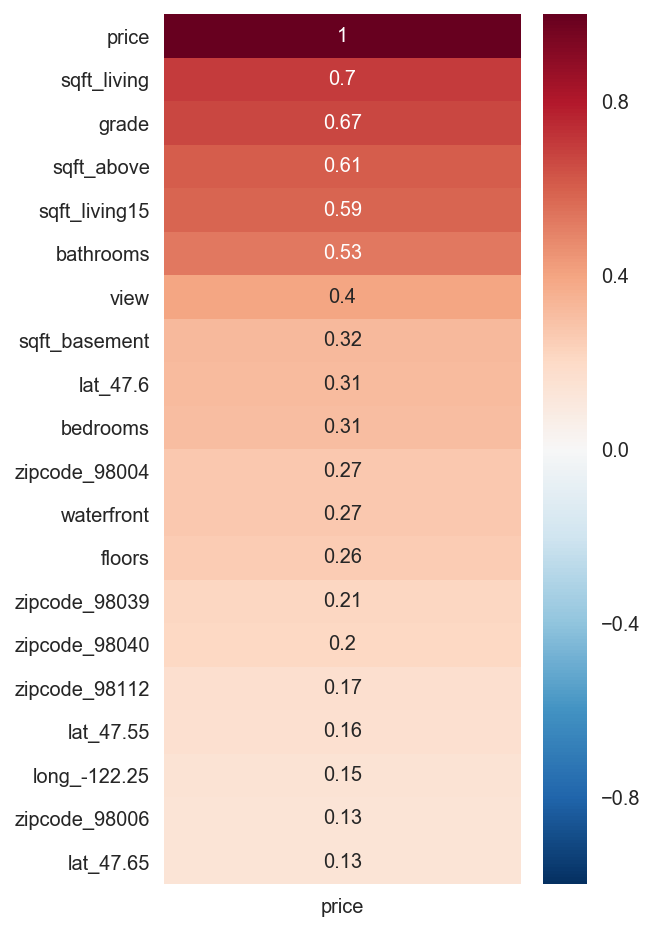

In [372]:
plt.figure(figsize=(4, 8))
tempdf = df.corr()[['price']].sort_values('price', ascending=False).iloc[:20, :]
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)

In [546]:
X = df.drop(['price'], axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# outlier sanitization of the training set
factor = 5
y_train[np.abs(y_train - y_train.mean()) > (factor * y_train.std())] = y_train.mean() + factor*y_train.std()

# scale the price
ss_price = StandardScaler()
y_train = ss_price.fit_transform(y_train)
y_test = ss_price.transform(y_test)

(17290, 187) (17290,) (4323, 187) (4323,)


## Linear Regression Model

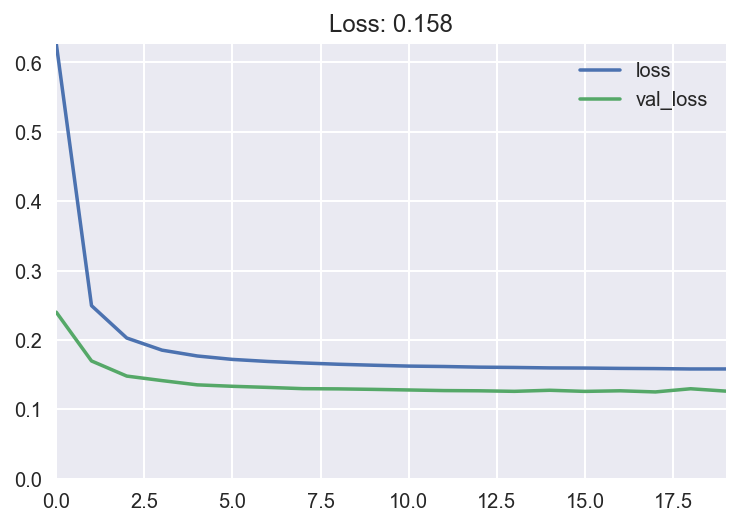

In [364]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(X.shape[1],)))

lr_model.compile('adam', 'mean_squared_error')

lr_history = lr_model.fit(X_train, y_train, epochs=20, verbose=0, validation_split=0.1)
plot_loss(lr_history)

In [365]:
lr_model.evaluate(X_test, y_test, verbose=0)

0.19560456495682951

In [354]:
# weights data frame
lr_wdf = pd.DataFrame(lr_model.get_weights()[0].T, 
                      columns=df.drop(['price'], axis=1).columns).T.sort_values(0, ascending=False)
lr_wdf.columns = ['feature_weight']
lr_wdf.iloc[:20,:]

,feature_weight
zipcode_98039,1.52
waterfront,1.36
zipcode_98004,1.06
zipcode_98112,0.72
zipcode_98040,0.59
zipcode_98105,0.43
zipcode_98109,0.43
lat_47.6,0.37
zipcode_98102,0.35
zipcode_98119,0.34


## Deep Model

The loss is behaving incosistently between runs, this one was good but the previous ones were bad. Needs debugging.

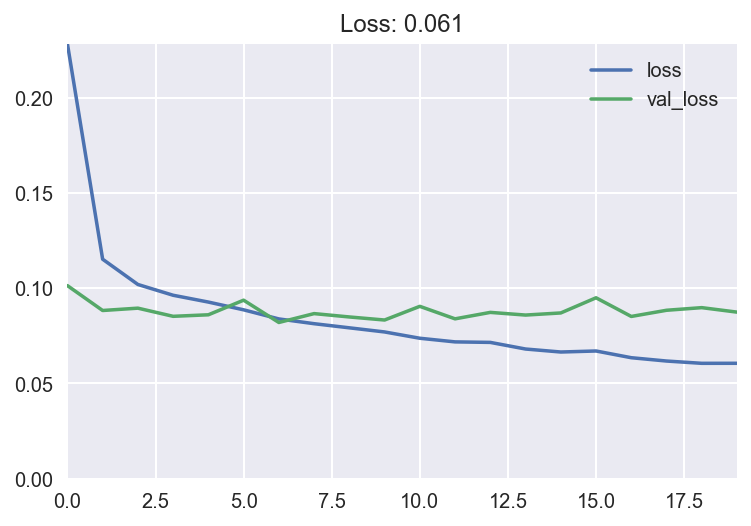

In [547]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

# early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=20, verbose=0, validation_split=0.1)
#                               callbacks=[early_stop])
plot_loss(deep_history)

In [548]:
deep_model.evaluate(X_test, y_test, verbose=0)

0.1333130705569964

In [346]:
# func = K.function([deep_model.layers[0].input], [deep_model.layers[1].output])
# func([X_test[0:10, :]])

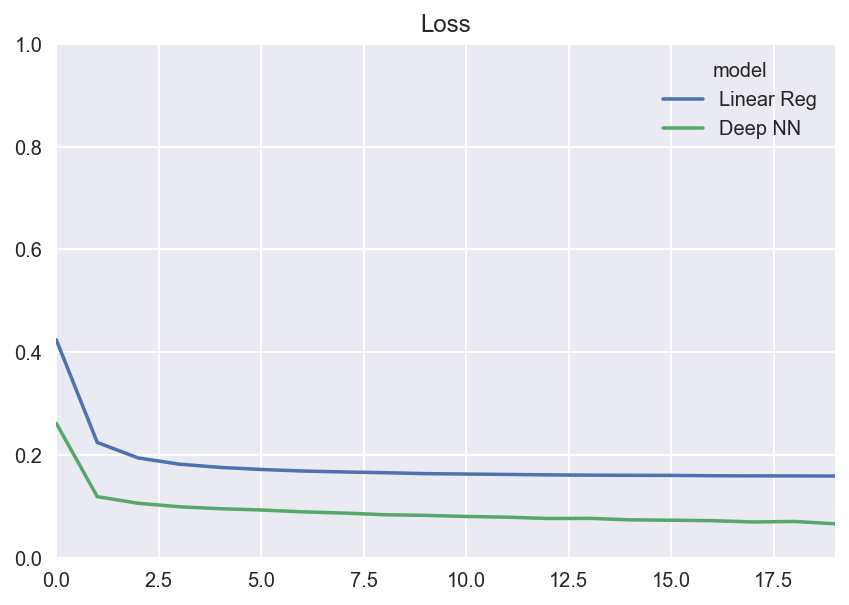

In [328]:
plot_compare_histories([lr_history, deep_history], ['Linear Reg', 'Deep NN'], plot_accuracy=False)

In [385]:
def output_dollars(num):
    return '$'+str("{:,}".format(int(num)))

print('Average house price:', output_dollars(rawdf['price'].mean()))

real_prices = ss_price.inverse_transform(y_test)

train_prices = ss_price.inverse_transform(y_train)
dumb_prices = np.zeros(real_prices.shape)
dumb_prices.fill(train_prices.mean())
dumb_error =mean_absolute_error(real_prices, dumb_prices)
print('Dumb model error:', output_dollars(dumb_error))

lr_predictions = lr_model.predict(X_test).ravel()
lr_prices = ss_price.inverse_transform(lr_predictions)
lr_error = mean_absolute_error(real_prices, lr_prices)
print('Linear model error:', output_dollars(lr_error))

deep_predictions = deep_model.predict(X_test).ravel()
deep_prices = ss_price.inverse_transform(deep_predictions)
deep_error = mean_absolute_error(real_prices, deep_prices)
print('Deep model error:', output_dollars(deep_error))

print(r2_score(real_prices, dumb_prices), r2_score(real_prices, lr_prices), r2_score(real_prices, deep_prices))

Average house price: $540,088
Dumb model error: $229,981
Linear model error: $87,390
Deep model error: $67,452
-0.000699456510588 0.813018926593 0.870178754915
